# Components of StyleGAN
In this notebook, I implemented various components of StyleGAN, including the truncation trick, the mapping layer, noise injection, adaptive instance normalization (AdaIN), and progressive growing.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## Truncation Trick
The first component that I implemented is the truncation trick. This is done after the model is trained and when you are sampling beautiful outputs. The truncation trick resamples the noise vector $z$ from a truncated normal distribution which allows you to tune the generator's fidelity/diversity. The truncation value is at least 0, where 1 means there is little truncation (high diversity) and 0 means the distribution is all truncated except for the mean (high quality/fidelity). This trick is not exclusive to StyleGAN.

In [6]:
from scipy.stats import truncnorm # The distrubution
def get_truncated_noise(n_samples, z_dim, truncation):
  lower_bound = -truncation
  upper_bound = truncation
  # Sample from the imported distribution
  truncated_noise = truncnorm.rvs(lower_bound, upper_bound, size=(n_samples, z_dim))
  return torch.Tensor(truncated_noise)

## Mapping $z$ → $w$

In [7]:
class MappingLayers(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, w_dim),
        )

    def forward(self, noise):
        return self.mapping(noise)

## Random Noise Injection
Next, I implemented the random noise injection that occurs before every AdaIN block.

In [24]:
class InjectNoise(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.weights = nn.Parameter(
        torch.randn(1, channels, 1, 1)
    )

  def forward(self, image):
    noise_shape = (image.size(0), 1, image.size(2), image.size(3))
    noise = torch.randn(noise_shape, device=image.device)

    return image + self.weights * noise

## Adaptive Instance Normalization (AdaIN)
To increase control over the image, I inject $w$ — the intermediate noise vector — multiple times throughout StyleGAN. This is done by transforming it into a set of style parameters and introducing the style to the image through AdaIN. Given an image ($x_i$) and the intermediate vector ($w$), AdaIN takes the instance normalization of the image and multiplies it by the style scale ($y_s$) and adds the style bias ($y_b$). We need to calculate the learnable style scale and bias by using linear mappings from $w$.

# $ \text{AdaIN}(\boldsymbol{\mathrm{x}}_i, \boldsymbol{\mathrm{y}}) = \boldsymbol{\mathrm{y}}_{s,i} \frac{\boldsymbol{\mathrm{x}}_i - \mu(\boldsymbol{\mathrm{x}}_i)}{\sigma(\boldsymbol{\mathrm{x}}_i)} + \boldsymbol{\mathrm{y}}_{b,i} $


In [9]:
class AdaIN(nn.Module):
  def __init__(self, channels, w_dim):
    super().__init__()
    self.instance_normalizer = nn.InstanceNorm2d(channels)
    self.style_scalar = nn.Linear(w_dim, channels)
    self.style_shifter = nn.Linear(w_dim, channels)

  def forward(self, image, w):
    normalized = self.instance_normalizer(image)  # b, c, h, w
    # Apply styles to each channel of the image
    scale = self.style_scalar(w)[:, :, None, None] # b, c, 1, 1
    shift = self.style_shifter(w)[:, :, None, None] # b, c, 1, 1
    styled_image = scale * normalized + shift

    return styled_image

## Progressive Growing in StyleGAN

In [19]:
class GeneratorBlock(nn.Module):
  def __init__(self, w_dim, in_chan, out_chan, kernel_size, starting_size, use_upsample=True):
    super().__init__()
    self.use_upsample = use_upsample
    if self.use_upsample:
      self.upsample = nn.Upsample(size=starting_size, mode="bilinear", align_corners=False)
    self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=1)
    self.inject_noise = InjectNoise(out_chan)
    self.adain = AdaIN(out_chan, w_dim)
    self.activation = nn.LeakyReLU(0.2)

  def forward(self, x, w):
    if self.use_upsample:
      x = self.upsample(x)
    x = self.conv(x)
    x = self.inject_noise(x)
    x = self.adain(x, w)
    x = self.activation(x)
    return x

In [21]:
class Generator(nn.Module):
  def __init__(self, z_dim, w_dim, map_hidden_dim, in_chan, out_chan,
               kernel_size, hidden_chan):
    super().__init__()
    self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
    self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
    self.block0 = GeneratorBlock(w_dim, in_chan, hidden_chan, kernel_size, 4, use_upsample=False)
    self.block1 = GeneratorBlock(w_dim, hidden_chan, hidden_chan, kernel_size, 8)
    self.block2 = GeneratorBlock(w_dim, hidden_chan, hidden_chan, kernel_size, 16)
    self.block1_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
    self.block2_to_image = nn.Conv2d(hidden_chan, out_chan, kernel_size=1)
    self.alpha = 0.2


  def upsample_to_match_size(self, smaller_image, bigger_image):
    return F.interpolate(smaller_image,
                         size=bigger_image.shape[-2:],
                         mode='bilinear')

  def forward(self, noise, return_intermediate=False):
    x = self.starting_constant
    w = self.map(noise)
    x = self.block0(x, w) # No upsampling
    x_small = self.block1(x, w) # First generator run output
    x_small_image = self.block1_to_image(x_small)
    x_big = self.block2(x_small, w) # Second generator run output
    x_big_image = self.block2_to_image(x_big)
    x_small_upsample = self.upsample_to_match_size(x_small_image, x_big_image) # Upsample first generator run output to be same size as second generator run output

    interpolation = self.alpha * x_big_image + (1 - self.alpha) * x_small_upsample

    if return_intermediate:
      return interpolation, x_small_upsample, x_big_image
    return interpolation

## Running StyleGAN

In [25]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = Generator(
    z_dim=z_dim,
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan,
    kernel_size=3,
    hidden_chan=256
)

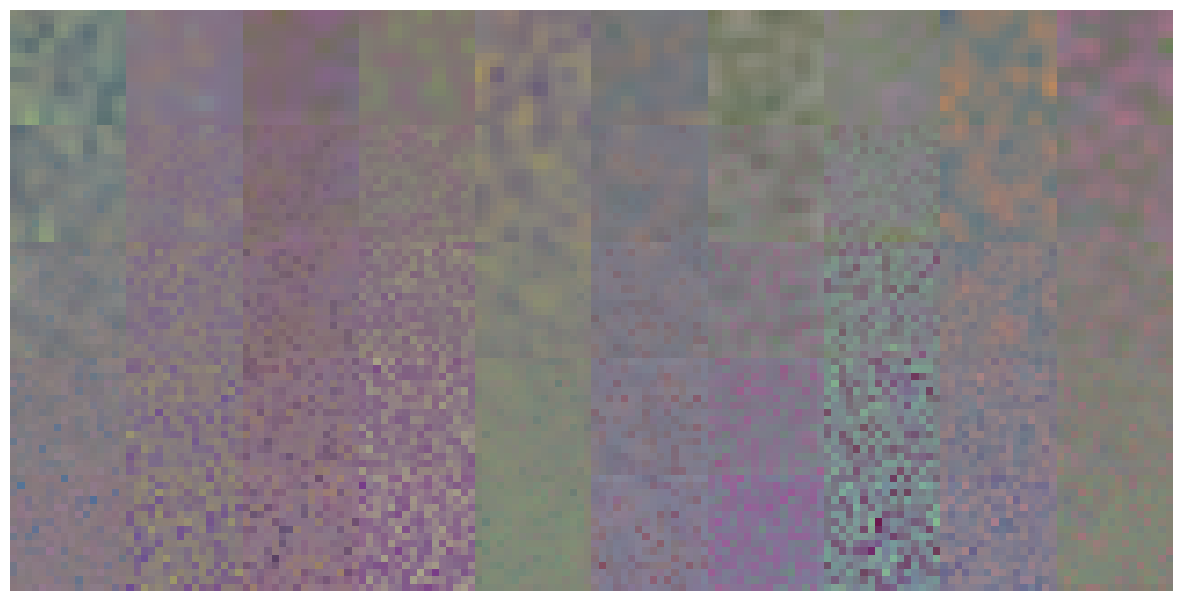

In [26]:
viz_samples = 10
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise,
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
mu_stylegan = mu_stylegan.train()
